In [1]:
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
import multiprocessing

import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())


import time
import torch.backends.cudnn as cudnn
import torchvision.models as models
import cv2
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
class FaceDetection():
    
    def __init__(self, path2img = 'figures/fig.jpg', path2class = './haarcascade_frontalface_alt.xml'):
        
        #Load image
        self.img_original = cv2.imread(path2img)
        
        # Convert to RGB colorspace
        self.img_original = self.convertToRGB(self.img_original)
        
        # copy original image
        self.img_with_detections = np.copy(self.img_original)
        
        #convert image to gray (opencv expects gray images)
        self.gray_img = self.convertToGray(self.img_original)

        #load cascade classifier (haarcascade) training file
        self.haar_face_cascade = cv2.CascadeClassifier(path2class)

        #Detect multiscale images 
        self.faces = self.haar_face_cascade.detectMultiScale(self.gray_img, scaleFactor=1.1, minNeighbors=5);

    def number_faces(self):
        #print the number of faces found 
        print('Faces found: ', len(self.faces))

    def convertToGray(self, img):
        # Convert the RGB  image to grayscale
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    def convertToRGB(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    def detection(self):
    
        faces_crop = []
        for (x, y, w, h) in self.faces:  
            obj = self.img_with_detections[y:y + h, x:x + w]
            faces_crop.append(obj)
            cv2.rectangle(self.img_with_detections, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
        return faces_crop

In [3]:
FaceDetection = FaceDetection()

In [4]:
FaceDetection.number_faces()

Faces found:  11


In [5]:
faces_crop = FaceDetection.detection()
(img_original, img_with_detections) =  (FaceDetection.img_original, FaceDetection.img_with_detections)

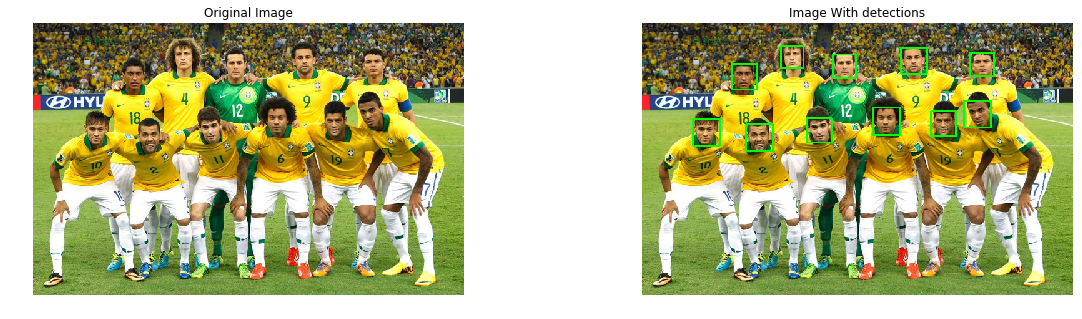

In [6]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(img_original)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1,2,2)
#convert image to RGB and show image 
plt.imshow(img_with_detections)
plt.title('Image With detections')
plt.axis('off')

fig.savefig('figures/fig_detection.png')

In [7]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)
cpu_count = multiprocessing.cpu_count()
print('cpu_count: ', cpu_count)

GPU available: True
cpu_count:  4


In [8]:
path2data = 'all/'
path2trainData = path2data + 'training.csv'
path2testData = path2data + 'test.csv'

In [9]:
augseq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
   # iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
    iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
    ])),
])


In [10]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, X, y, transforms=None):
        
        self.transform = transforms    
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        image = self.X[index]
        keypoints = self.y[index]        
        
        if self.transform:
            image = self.transform(image)
            
        return image, keypoints

    def __len__(self):
        return len(self.X)

In [11]:
class ToTensor(object):

    def __call__(self, image):
        # imagem numpy: C x H x W
        # imagem torch: C X H X W
                    
        image = image.transpose((0, 1, 2))
        return torch.from_numpy(image)

In [12]:
class CloneArray(object):
    
    def __call__(self, image):
        image = image.repeat(3, axis=0)
        return image

In [13]:
class imaguaHide(object):
    
    def __call__(self, image):
        image = augseq.augment_image(image.transpose((1, 2, 0))).transpose(2,0,1)
        return image

In [14]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [15]:
data_transforms = {
    'train': transforms.Compose([
#         imaguaHide(),
        CloneArray(),
        ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
#         imaguaHide(),
        CloneArray(),
        ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

In [16]:
def get_data(path2data, is_test = False):

    df = pd.read_csv(path2data)
    df = df.dropna()

    df['Image'] = df['Image'].apply(lambda img:  np.fromstring(img, sep = ' '))
    X = np.vstack(df['Image'].values)
    X = X / 255.   # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1) # return each images as 1 x 96 x 96

    if not is_test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48 
        y = y.astype(np.float32)
    else:
        y = np.zeros((len(X)))

    return X, y

In [17]:
X_train, y_train = get_data(path2trainData)
X_test, y_test = get_data(path2testData, is_test=True)

X_train = augseq.augment_images(X_train).reshape(-1,1,96,96)
X_test = augseq.augment_images(X_test).reshape(-1,1,96,96)

In [18]:
dsets = {
    'train': FaceKeyPointsDataset(X_train, y_train, transforms=data_transforms['train']),
    'valid': FaceKeyPointsDataset(X_train, y_train, transforms=data_transforms['valid']),
    'test':  FaceKeyPointsDataset(X_test, y_test, transforms=data_transforms['valid']),
}

In [19]:
batch_size = 32
random_seed = 3
valid_size = 0.2
shuffle = True

In [20]:
num_train = len(dsets['train'])
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

sampler = {'train': train_sampler,
          'valid': valid_sampler,
          'test': None}

In [21]:
def create_dataLoader(dsets, batch_size, sampler={'train': None, 'valid': None,'test': None},
                      pin_memory=False):
  
    dset_loaders = {} 
    for key in dsets.keys():
        if sampler[key] != None:
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, sampler=sampler[key], pin_memory=pin_memory)
        else:          
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=False)

    return dset_loaders

In [22]:
dset_loaders = create_dataLoader(dsets, batch_size, sampler, pin_memory=False)

In [23]:
image, keypoints = next(iter(dset_loaders['train']))
print(image.size(), keypoints.size())

torch.Size([32, 3, 96, 96]) torch.Size([32, 30])


In [24]:
def plot_face_Keypoints(dset_loaders, is_train = True, preds_test = [], preds_train = []):
    

    X, y = next(iter(dset_loaders))
    X, y = X.numpy(), y.numpy()
    
    plt.figure(figsize=(20,10))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)
        
        rand_img = random.randrange(0, X.shape[0])
        
        img = denormalize(X[rand_img,:,:,:])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img, cmap = 'gray')

        if is_train:
            cordinates = y[rand_img, :] * 48 + 48

        else:
            cordinates = preds_test.numpy()[rand_img] * 48 + 48

        if (len(preds_train) !=0):
            plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
            cordinates_train = preds_train[rand_img].numpy()
            cordinates_train = cordinates_train*48 + 48
            plt.scatter(cordinates_train[::2], cordinates_train[1::2], marker='o', c='r', s=10)

        plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
        plt.title('Sample n {}'.format(rand_img))
        plt.axis('off')

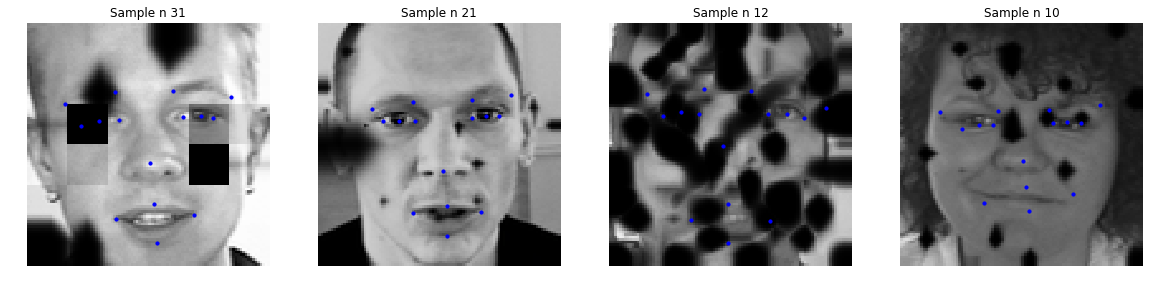

In [25]:
plot_face_Keypoints(dset_loaders['train'])

In [26]:
nb_out = 30
print('Number of outputs: {}'.format(nb_out))

Number of outputs: 30


In [27]:
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
#             conv_dw(256, 512, 2),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 1024, 2),
#             conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(256, nb_out)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x

In [ ]:
model = MobileNet()

if use_gpu:
    model.cuda() 